In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision.all import *
from fastai.callback.tensorboard import TensorBoardCallback
tensorboard_dir = "/home/stephen/pythonProject1/mylogdir/"
from shapely import wkt

In [2]:
from fastai.vision.all import *
from typing import Tuple, List, Union
from typing_extensions import Literal, TypedDict
from pathlib import Path
import json
from re import match
from functools import lru_cache
from sklearn.model_selection import train_test_split
import PIL
from fastai.data.core import DataLoaders
import shutil
from fastai.callback.all import *
from fastprogress import fastprogress
fastprogress.printing = lambda: True

In [3]:
def get_labels_in_memory(my_dir:Path, trim_by_size=False,trim_size_px=25*25)-> dict:
    return_dict = {}
    n_items = 0
    n_not_trimmed =0
    for item in my_dir.glob('*_post_disaster.json'):
        with open(item.absolute()) as fp:
            for item in json.load(fp)['features']['xy']:
                n_items +=1
                uid = item['properties']['uid']
                output = item['properties']['subtype']
                if trim_by_size:
                    poly = wkt.loads(item['wkt'])
                    if poly.area > trim_size_px:
                        n_not_trimmed+=1
                        return_dict[uid] = output
                else:
                    return_dict[uid] = output
    if trim_by_size:
        print(f"Shown {n_not_trimmed} out of {n_items}")
    return return_dict

label_list = get_labels_in_memory(Path('/home/stephen/AwsMLHack/data/xview/train_images_labels_targets/train/labels'),trim_by_size=True)

label_types = set([x for x in label_list.values()])
print(label_types)

Shown 83825 out of 162787
{'un-classified', 'no-damage', 'major-damage', 'minor-damage', 'destroyed'}


In [4]:
# Modify so that we only care about major-damage/destroyed, no-damage and minor damage gets treated as undamaged
# Ignore un-classified
unclassified_uids = [k for k,v in label_list.items() if v =='un-classified']

label_list = {k:'undamaged' if v in ['no-damage'] else 'damaged' for k,v in label_list.items() if v not in ['un-classified','minor-damage']}
label_list_damage_type = dict(
    damaged = [k for k,v in label_list.items() if v=='damaged'],
    undamaged = [k for k,v in label_list.items() if v=='undamaged'],

)

In [5]:
print(len(label_list_damage_type['damaged']))
print(len(label_list_damage_type['undamaged']))

14128
61472


In [6]:
labels = ['undamaged','damaged']
# UID
uid_extract = re.compile('[a-fA-F0-9]{8}-[a-fA-F0-9]{4}-[a-fA-F0-9]{4}-[a-fA-F0-9]{4}-[a-fA-F0-9]{12}')

print(uid_extract.search("hurricane-michael_00000549_pre_disaster_ffe60f5c-037d-48d7-9fb1-34962a32241d.png")[0])

@lru_cache
def label_func(filename:Union[str,Path])-> str:
    if not isinstance(filename,str):
        return label_list[uid_extract.search(filename.absolute().__str__())[0]]
    else:
        return label_list[uid_extract.search(filename)[0]]
label_func("hurricane-michael_00000549_pre_disaster_ffe60f5c-037d-48d7-9fb1-34962a32241d.png")


ffe60f5c-037d-48d7-9fb1-34962a32241d


'undamaged'

In [7]:
image_filenames = []
for image_filename in Path('/home/stephen/AwsMLHack/data/xview/train_images_labels_targets/train/output').glob("*.png"):
    if uid_extract.search(image_filename.stem)[0] in label_list.keys():
        image_filenames.append(image_filename.absolute().__str__())

print(len(image_filenames))

62616


In [8]:
base = f"/home/stephen/AwsMLHack/data/xview_data/"
for label in labels:
    p = Path(f"{base}{label}/")
    if p.exists():
        shutil.rmtree(p.absolute().__str__())
    p.mkdir(parents=True)
for file in image_filenames:



    try:
        shutil.copy(file,f"{base}{label_func(file)}/{Path(file).name}")
    except Exception as e:
        print(file)
        print(e)
        pass

In [9]:
def open_image(fname, size=224):
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0


In [10]:
@lru_cache
def label_func(filename:Union[str,Path])-> str:
    if type(filename) != str:
        return label_list[uid_extract.search(filename.absolute().__str__())[0]]
    else:
        return label_list[uid_extract.search(filename)[0]]
from fastai.vision.core import *
from fastai.vision.data import *

db = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter = RandomSplitter(valid_pct=0.2,seed=42),
    get_y = label_func,
    item_tfms=Resize(256),
)

True


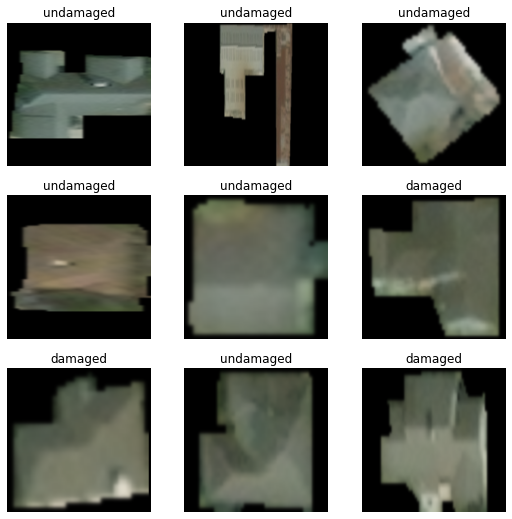

In [11]:
batch_tfms = [Normalize.from_stats(*imagenet_stats)] #

dl = db.dataloaders('/home/stephen/AwsMLHack/data/xview_data/',shuffle=True,bs=64,batch_tfms=batch_tfms)
print(dl.shuffle)
dl.show_batch()

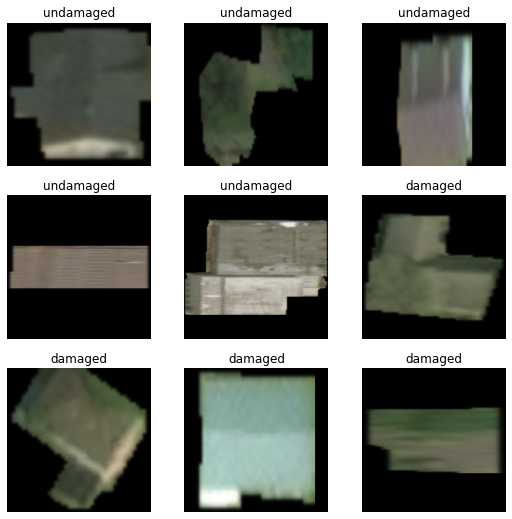

In [12]:
dl.show_batch()

Epoch 2: reducing lr to 0.0002211205499447308


Epoch 2: reducing lr to 1.0796960686756474e-10


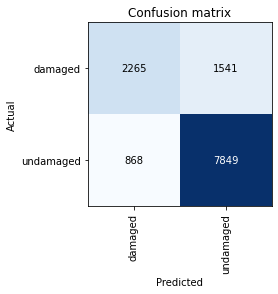

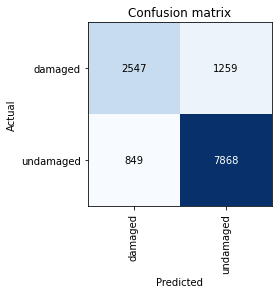

In [13]:
#FloatTensor([0.55,0.45]).cuda()
cb = [TensorBoardCallback(log_dir= tensorboard_dir + "default-loss-normalised"), ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2)]
learn = cnn_learner(dl, resnet34, metrics=[error_rate,Recall(labels=labels),Precision(labels=labels)],cbs=cb)
learn.fit_one_cycle(5,slice(0.003,0.008))
learn.save("basic-bitch-model1")
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
learn.unfreeze()
learn.fit_one_cycle(8,slice(0.00005,0.0001))
interp = ClassificationInterpretation.from_learner(learn)
learn.save("basic-bitch-model1")
interp.plot_confusion_matrix()


In [ ]:
learn.fit_one_cycle(10,slice(0.0005,0.001))
interp = ClassificationInterpretation.from_learner(learn)
learn.save("basic-bitch-model1")
interp.plot_confusion_matrix()


In [13]:
getattr(dl.train_ds, 'loss_func', None)

FlattenedLoss of CrossEntropyLoss()

In [ ]:
cb = TensorBoardCallback(log_dir= tensorboard_dir + "Focal-Gamma3")
learn = cnn_learner(dl, resnet34, metrics=[error_rate,Recall(labels=labels),Precision(labels=labels)], loss_func=FocalLossFlat(gamma=3),cbs=cb)
learn.fit_one_cycle(3,0.002)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
learn.fit_one_cycle(3,slice(0.00005,0.0001))
interp = ClassificationInterpretation.from_learner(learn)
learn.save("basic-bitch-model1")
interp.plot_confusion_matrix()

In [ ]:
cb = TensorBoardCallback(log_dir= tensorboard_dir + "Focal-Gamma5")
learn = cnn_learner(dl, resnet34, metrics=[error_rate,Recall(labels=labels),Precision(labels=labels)], loss_func=FocalLossFlat(gamma=5),cbs=cb)
learn.fit_one_cycle(5,0.002)
learn.show_results(max_n=16)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

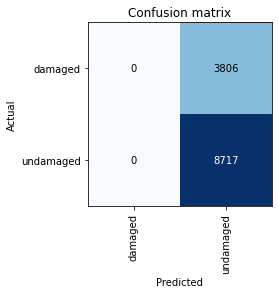

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [18]:
learn.fit_one_cycle(5,0.002,)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

epoch,train_loss,valid_loss,error_rate,recall_score,precision_score,time
0,0.088801,0.074748,0.305917,0.796834,0.771264,03:05


RuntimeError: CUDA out of memory. Tried to allocate 90.00 MiB (GPU 0; 7.77 GiB total capacity; 5.35 GiB already allocated; 82.56 MiB free; 5.51 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
learn.show_results()

In [ ]:
learn.save("basic-bitch-model")

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3,slice(0.00005,0.0001))
interp = ClassificationInterpretation.from_learner(learn)
learn.save("basic-bitch-model1")
interp.plot_confusion_matrix()

In [ ]:
learn.show_results()

In [ ]:
learn.fit_one_cycle(1,0.002)
interp = ClassificationInterpretation.from_learner(learn)
learn.save("basic-bitch-model2")
interp.plot_confusion_matrix()

In [ ]:
learn.show_results()

In [ ]:
learn.fit_one_cycle(1,0.002)
interp = ClassificationInterpretation.from_learner(learn)
learn.save("basic-bitch-model3")
interp.plot_confusion_matrix()

In [ ]:
learn.show_results()

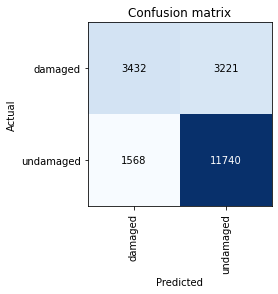

In [28]:
learn.fit_one_cycle(1,0.002)
interp = ClassificationInterpretation.from_learner(learn)
learn.save("basic-bitch-model4")
interp.plot_confusion_matrix()

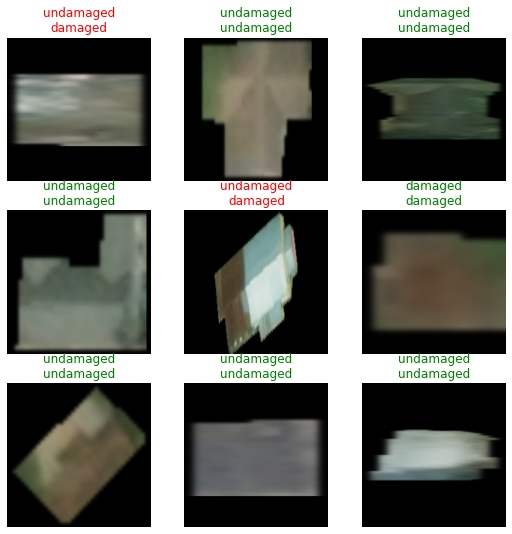

In [29]:
learn.show_results()

In [30]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1,slice(0.00001,0.001))
interp = ClassificationInterpretation.from_learner(learn)
learn.save("basic-bitch-model5")
interp.plot_confusion_matrix()

In [ ]:
learn.show_results()

In [ ]:
learn.fit_one_cycle(1,0.0001)
interp = ClassificationInterpretation.from_learner(learn)
learn.save("basic-bitch-model6")
interp.plot_confusion_matrix()

In [ ]:
learn.show_results()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
learn.show_results(max_n=25)